# Cellranger V4 onwards
![dandelion_logo](img/dandelion_logo_illustration.png)

From cellranger V4 onwards, there is now an `airr_rearrangement.tsv` file that can be used directly with `Dandelion`. However, doing so will miss out on the reannotation steps but that is entirely up to you.

We will download the *airr_rearrangement.tsv* file from here:
```bash
# bash
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv
```


**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_header()

dandelion==0.0.29 pandas==1.1.4 numpy==1.19.4 matplotlib==3.3.3 networkx==2.5 scipy==1.5.3 skbio==0.5.6


Basically it's as simple as doing this:

In [2]:
# read in the airr_rearrangement.tsv file
file_location = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv'
vdj = ddl.read_10x_airr(file_location, sample_id = 'sc5p_v2_hs_PBMC_10k')
vdj

Dandelion class object with n_obs = 0 and n_contigs = 2093
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'sample_id', 'locus'
    metadata: None
    distance: None
    edges: None
    layout: None
    graph: None

It returns an uninitiated `Dandelion` object mainly due to load times, but you can choose to change `initialize_dandelion = True` instead.

We will continue with the rest of the filtering part of the analysis to show how it slots smoothly with the rest of the workflow.

**Import modules for use with scanpy**

In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


**Import the transcriptome data**

In [4]:
adata = sc.read_10x_h5('sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5', gex_only=True)
adata.obs['sample_id'] = 'sc5p_v2_hs_PBMC_10k'
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 10553 × 36601
    obs: 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'

Run QC on the transcriptome data.

In [5]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 10553 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna'
    var: 'gene_ids', 'feature_types', 'genome'

Run the filtering of bcr data. Note that I'm using the `Dandelion` object as input rather than the pandas dataframe (yes both types of input will works. In fact, a file path to the .tsv will work too).

In [7]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_bcr(vdj, adata)

Scanning for poor quality/ambiguous contigs with 3 cpus


Annotating in anndata obs slot : 100%|██████████| 10553/10553 [00:00<00:00, 512178.78it/s]


Finishing up filtering
Initializing Dandelion object


**Check the output V(D)J table**

The vdj table is returned as a `Dandelion` class object in the `.data` slot (described in further detail in the next notebook); if a file was provided for `filter_bcr` above, a new file will be created in the same folder with the `filtered` prefix. Note that this `vdj` table is indexed based on contigs (sequence_id).

In [8]:
vdj

Dandelion class object with n_obs = 515 and n_contigs = 1031
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'sample_id', 'locus', 'umi_count'
    metadata: 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_heavy', 'v_call_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_light_0', 'umi_count_light_1', 'junction_aa_heavy', 'junction_aa_light', 'status', 'productive', 'isotype', 'vdj_status_detail', 'vdj_status'
    distance: None
    edges: None
    l

**Check the AnnData object as well**

And the `AnnData` object is indexed based on cells.

In [9]:
adata

AnnData object with n_obs × n_vars = 7331 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr'
    var: 'gene_ids', 'feature_types', 'genome'

**The number of cells that actually has a matching BCR can be tabluated.**

In [10]:
pd.crosstab(adata.obs['has_bcr'], adata.obs['filter_bcr'])

filter_bcr,False
has_bcr,
True,522
No_BCR,6809


In [11]:
pd.crosstab(adata.obs['has_bcr'], adata.obs['bcr_QC_pass'])

bcr_QC_pass,False,True,No_BCR
has_bcr,,,
True,7,515,0
No_BCR,0,0,6809


In [12]:
pd.crosstab(adata.obs['bcr_QC_pass'], adata.obs['filter_bcr'])

filter_bcr,False
bcr_QC_pass,
False,7
True,515
No_BCR,6809


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [13]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

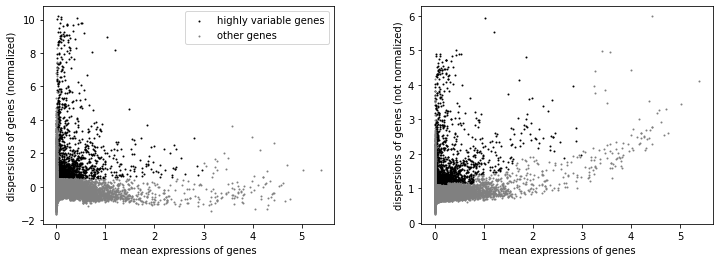

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [15]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [16]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'genome' as categorical


**Run PCA**

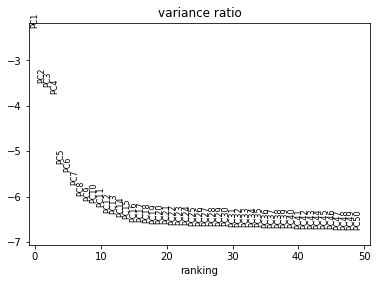

In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [18]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding BCR**

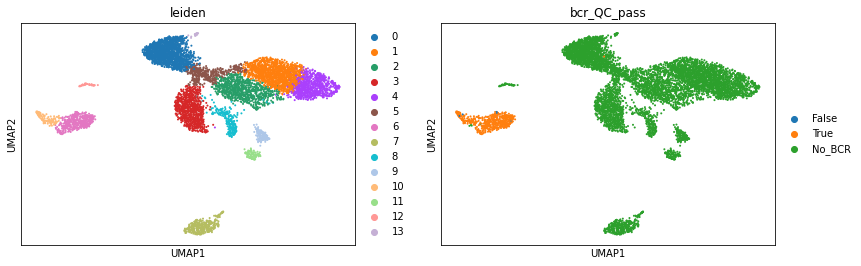

In [19]:
sc.pl.umap(adata, color=['leiden', 'bcr_QC_pass'])

**Visualizing some B cell genes**

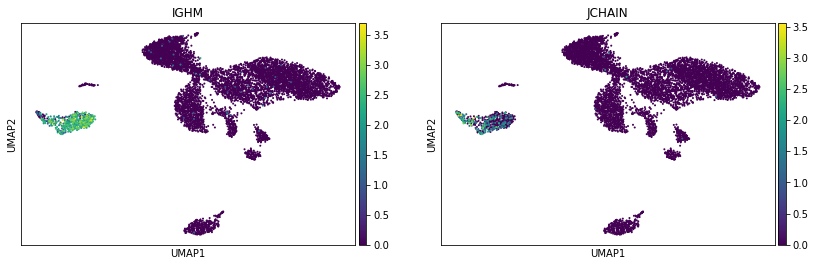

In [20]:
sc.pl.umap(adata, color=['IGHM', 'JCHAIN'])

**Save AnnData**

We can save this `AnnData` object for now.

In [21]:
adata.write('adata2.h5ad', compression = 'gzip')

... storing 'feature_types' as categorical
... storing 'genome' as categorical


**Save dandelion**

To save the vdj object, we have two options - either save the `.data` and `.metadata` slots with pandas' functions:

In [22]:
vdj.data.to_csv('filtered_vdj_table2.tsv', sep = '\t')

In [23]:
vdj.write_h5('dandelion_results2.h5', complib = 'bzip2')